In [1]:
from yahoo_finance import Share
from datetime import datetime, date
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pickle

pd.set_option('display.max_columns', 50)


def getStock(start_date, id):
    """
    datetime format example: '2016-01-28'
    """
    stock = Share(str(id)+'.TW')
    today = date.today() #todays date
    data = stock.get_historical(start_date, str(today))
    return data

In [2]:
taiwan50_symbols = [1101, 1102, 1216, 1301, 1303, 1326, 1402, 1722, 2002, 2105, 2201, 2207, 2301, 2303, 2308, 2311, 2317,
           2324, 2325, 2330, 2347, 2353, 2354, 2357, 2382, 2409, 2412, 2454, 2474, 2498, 2801, 2880, 2881, 2882, 2883,
           2885, 2886, 2890, 2891, 2892, 2912, 3008, 3045, 3231, 3481, 3673, 3697, 4904, 5880, 6505]

In [3]:
len(taiwan50_symbols)

50

In [4]:
def create_dataframe(data):
    # Create df from data
    df = pd.DataFrame(data)
    # Set date as index
    df = df.set_index('Date')
    # Convert index str to datetime object
    df.index = pd.to_datetime(df.index)
    
    # Create dfMain for reordering data
    start_date = '2000-01-01'
    end_date = '2017-03-03'
    dates = pd.date_range(start_date, end_date)
    dfMain = pd.DataFrame(index=dates)
    dfMain = dfMain.join(df)
    dfMain.dropna(inplace=True)
    
    # Convert str values to numeric
    dfMain = dfMain.convert_objects(convert_numeric=True)
    
    # Drop suspension dates
    dfMain.drop(dfMain[dfMain['Volume'] == 0].index, inplace=True)
    
    # Drop data anomoly based on volume
    mean = dfMain['Volume'].mean()
    std = dfMain['Volume'].std()
    dfMain.drop(dfMain[dfMain['Volume'] - mean > 5 * std].index, inplace=True)
    # Drop Symbol Column
    del dfMain['Symbol']
    
    return dfMain

In [152]:
# # Download and create Taiwan 50 dataframes
# taiwan50 = {}

# for symbol in taiwan50_symbols:
#     try:
#         data_temp = getStock('2000-01-01', symbol)
#     except (KeyboardInterrupt, SystemExit):
#         raise
#     except:
#         print("Error symbol: {}".format(symbol))
#     else:
#         taiwan50[symbol] = create_dataframe(data_temp)

/home/calvinjku/anaconda3/envs/chimp/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Error symbol: 2409
Error symbol: 2412
Error symbol: 2454
Error symbol: 2498
Error symbol: 2880
Error symbol: 2881
Error symbol: 2883
Error symbol: 2891
Error symbol: 2892
Error symbol: 3008
Error symbol: 3045
Error symbol: 3231
Error symbol: 3481
Error symbol: 3673
Error symbol: 3697
Error symbol: 4904
Error symbol: 5880
Error symbol: 6505


In [153]:
# len(taiwan50)

32

In [157]:
# print(taiwan50.keys())

dict_keys([1216, 2882, 2308, 2885, 2886, 2311, 2890, 1101, 1102, 2317, 2002, 2324, 2325, 1303, 2201, 2330, 1402, 2207, 2912, 2801, 2474, 2347, 1326, 2353, 2354, 2382, 2357, 2105, 1722, 2303, 2301, 1301])


In [156]:
# for key in taiwan50:
#     taiwan50[key].to_csv('./data/' + str(key) + '.csv')

In [28]:
import glob

taiwan50 = {}

taiwan50_filenames = glob.glob('./data/*.csv')

for filename in taiwan50_filenames:
    taiwan50[int(filename[-8:-4])] = pd.DataFrame.from_csv(filename)

In [29]:
good_data_symbols = [1216, 2308, 2311, 2890, 1101, 1102, 2317, 2002, 2324, 2325, 1303, 2201, 2330, 1402, 2207, 
                     2912, 2801, 2474, 2347, 1326, 2353, 2354, 2382, 2357, 1722, 2303, 2301, 1301]

In [30]:
stocks = {key: taiwan50[key] for key in good_data_symbols}

In [31]:
def adjust_prices(dfMain):
    # Adjust Open, High, Low, Volume
    dfMain['Adj Factor'] = dfMain['Adj_Close'] / dfMain['Close']

    dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
    dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
    dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']
    dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

    dfMain.drop(['Adj Factor'], axis=1, inplace=True)
    
    return dfMain

In [32]:
def add_past_prices(dfMain):
    # Price Engineering
    # Get opens
    period_list = [1, 2, 3, 4, 5, 10, 21, 63, 100]
    for x in period_list:
        dfMain['-' + str(x) + 'd_Open'] = dfMain['Open'].shift(x)

    # Get adjCloses
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_adjClose'] = dfMain['Adj_Close'].shift(x)

    # Get highs
    period_list1 = range(1, 5 + 1)
    for x in period_list1:
        dfMain['-' + str(x) + 'd_High'] = dfMain['High'].shift(x)

    period_list2 = [10, 21, 63, 100]
    for x in period_list2:
        dfMain[str(x) + 'd_High'] = dfMain['High'].shift().rolling(window=x).max()

    # Get lows
    period_list1 = range(1, 5 + 1)
    for x in period_list1:
        dfMain['-' + str(x) + 'd_Low'] = dfMain['Low'].shift(x)

    period_list2 = [10, 21, 63, 100]
    for x in period_list2:
        dfMain[str(x) + 'd_Low'] = dfMain['High'].shift().rolling(window=x).min()
    
    return dfMain

In [33]:
def get_bases(dfMain):
    # Get Volume Bases
    dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
    dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

    # Get Spread Bases
    dfMain['Abs_Spread'] = np.abs(dfMain['Adj_Close'] - dfMain['Open'])
    dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()
    dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
    dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

    dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)
    
    return dfMain

In [34]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

In [35]:
def get_volumes(dfMain):
    # Volume Engineering
    # Get volumes
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_Vol'] = dfMain['Volume'].shift(x)

    # Get avg. volumes
    period_list = [10, 21, 63]
    for x in period_list:
        dfMain[str(x) + 'd_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=x).mean()

    # Get relative volumes 1
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_Vol1'] = dfMain['-' + str(x) + 'd_Vol'] / dfMain['100d_Avg_Vol']
        dfMain['-' + str(x) + 'd_Vol1'] = dfMain['-' + str(x) + 'd_Vol1'].apply(relative_transform)

    # Get relative avg. volumes 1
    period_list = [10, 21, 63]
    for x in period_list:
        dfMain[str(x) + 'd_Avg_Vol1'] = dfMain[str(x) + 'd_Avg_Vol'] / dfMain['100d_Avg_Vol']
        dfMain[str(x) + 'd_Avg_Vol1'] = dfMain[str(x) + 'd_Avg_Vol1'].apply(relative_transform)

    # Get relative volumes 2
    period_list = range(1, 5 + 1)
    for x in period_list:
        dfMain['-' + str(x) + 'd_Vol2'] = dfMain['-' + str(x) + 'd_Vol'] / dfMain['100d_Max_Vol']
        dfMain['-' + str(x) + 'd_Vol2'] = dfMain['-' + str(x) + 'd_Vol2'].apply(relative_transform)
    
    return dfMain

In [36]:
def get_spreads(dfMain):
    # Spread Engineering
    # Get spread
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63]

    for x in period_list1:
        dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_adjClose'] - dfMain['-' + str(x) + 'd_Open']    

    for x in period_list2:
        dfMain[str(x) + 'd_Spread'] = dfMain['-1d_adjClose'] - dfMain['-' + str(x) + 'd_Open']

    # Get relative spread
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63]

    for x in period_list1:
        dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_Spread'] / dfMain['100d_Avg_Spread']
        dfMain['-' + str(x) + 'd_Spread'] = dfMain['-' + str(x) + 'd_Spread'].apply(relative_transform)

    for x in period_list2:
        dfMain[str(x) + 'd_Spread'] = dfMain[str(x) + 'd_Spread'] / dfMain['100d_Max_Spread']
        dfMain[str(x) + 'd_Spread'] = dfMain[str(x) + 'd_Spread'].apply(relative_transform)

    return dfMain

In [37]:
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False

In [38]:
def get_wicks(dfMain):
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63, 100]
    for x in period_list1:
        dfMain.ix[:, '-' + str(x) + 'd_upperwick_bool'] = dfMain.apply(lambda row: upperwick(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_High']), axis=1)
        dfMain.ix[:, '-' + str(x) + 'd_lowerwick_bool'] = dfMain.apply(lambda row: lowerwick(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_Low']), axis=1)

    for x in period_list2:
        dfMain.ix[:, str(x) + 'd_upperwick_bool'] = dfMain.apply(lambda row: upperwick(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_High']), axis=1)
        dfMain.ix[:, str(x) + 'd_lowerwick_bool'] = dfMain.apply(lambda row: lowerwick(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_Low']), axis=1)

    return dfMain

In [39]:
def get_upperwick_length(open, adj_close, high):
    return high - max(open, adj_close)

def get_lowerwick_length(open, adj_close, low):
    return min(open, adj_close) - low

In [40]:
def wick_transform(dfMain):
    period_list1 = range(1, 5 + 1)
    period_list2 = [10, 21, 63]

    for x in period_list1:
        has_upperwicks = dfMain['-' + str(x) + 'd_upperwick_bool']
        has_lowerwicks = dfMain['-' + str(x) + 'd_lowerwick_bool']

        dfMain.loc[has_upperwicks, '-' + str(x) + 'd_upperwick'] = dfMain.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_High']), axis=1)
        dfMain.loc[has_lowerwicks, '-' + str(x) + 'd_lowerwick'] = dfMain.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(x) + 'd_Open'], row['-' + str(x) + 'd_adjClose'], row['-' + str(x) + 'd_Low']), axis=1)

        # Get relative upperwick length
        dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] / dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '100d_Avg_Spread']
        # Get relative lowerwick length
        dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] / dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '100d_Avg_Spread']

        # Transform upperwick ratio to int
        dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_upperwick_bool'], '-' + str(x) + 'd_upperwick'].apply(relative_transform)
        # Transform lowerwick ratio to int
        dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'] = dfMain.loc[dfMain['-' + str(x) + 'd_lowerwick_bool'], '-' + str(x) + 'd_lowerwick'].apply(relative_transform)

        # Assign 0 to no-upperwick days
        dfMain.loc[np.logical_not(dfMain['-' + str(x) + 'd_upperwick_bool']), '-' + str(x) + 'd_upperwick'] = 0
        # Assign 0 to no-lowerwick days
        dfMain.loc[np.logical_not(dfMain['-' + str(x) + 'd_lowerwick_bool']), '-' + str(x) + 'd_lowerwick'] = 0

    for x in period_list2:
        has_upperwicks = dfMain[str(x) + 'd_upperwick_bool']
        has_lowerwicks = dfMain[str(x) + 'd_lowerwick_bool']

        dfMain.loc[has_upperwicks, str(x) + 'd_upperwick'] = dfMain.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_High']), axis=1)
        dfMain.loc[has_lowerwicks, str(x) + 'd_lowerwick'] = dfMain.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(x) + 'd_Open'], row['-1d_adjClose'], row[str(x) + 'd_Low']), axis=1)

        # Get relative upperwick length
        dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] = dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] / dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], '100d_Avg_Spread']
        # Get relative lowerwick length
        dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] = dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] / dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], '100d_Avg_Spread']

        # Transform upperwick ratio to int
        dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'] = dfMain.loc[dfMain[str(x) + 'd_upperwick_bool'], str(x) + 'd_upperwick'].apply(relative_transform)
        # Transform lowerwick ratio to int
        dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'] = dfMain.loc[dfMain[str(x) + 'd_lowerwick_bool'], str(x) + 'd_lowerwick'].apply(relative_transform)

        # Assign 0 to no-upperwick days
        dfMain.loc[np.logical_not(dfMain[str(x) + 'd_upperwick_bool']), str(x) + 'd_upperwick'] = 0
        # Assign 0 to no-lowerwick days
        dfMain.loc[np.logical_not(dfMain[str(x) + 'd_lowerwick_bool']), str(x) + 'd_lowerwick'] = 0
        
    return dfMain

In [41]:
def get_trade_price(dfMain):
    dfMain['Trade Price'] = dfMain['Adj_Close']
    
    return dfMain

In [42]:
def drop_redundant_cols(dfMain):
    dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)
    
    return dfMain

In [43]:
def drop_na_rows(dfMain):
    dfMain.dropna(inplace=True)
    
    return dfMain

In [44]:
def preprocess_pipeline(dfMain):
    dfMain = adjust_prices(dfMain)
    dfMain = add_past_prices(dfMain)
    dfMain = get_bases(dfMain)
    dfMain = get_volumes(dfMain)
    dfMain = get_spreads(dfMain)
    dfMain = get_wicks(dfMain)
    dfMain = wick_transform(dfMain)
    dfMain = get_trade_price(dfMain)
    dfMain = drop_redundant_cols(dfMain)
    dfMain = drop_na_rows(dfMain)
    
    return dfMain

In [45]:
stocks_converted = {key: preprocess_pipeline(stocks[key]) for key in stocks}

In [46]:
# with open('stocks_converted.pickle', 'wb') as handle:
#     pickle.dump(stocks_converted, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('stocks_converted.pickle', 'rb') as handle:
    stocks_converted = pickle.load(handle)

In [3]:
stocks_converted.keys()

dict_keys([1216, 2308, 2311, 2890, 1101, 1102, 2317, 2002, 2324, 2325, 1303, 2201, 2330, 1722, 2207, 2912, 1301, 2801, 2474, 2347, 1326, 2353, 2354, 2382, 2357, 1402, 2301, 2303])

In [4]:
num_stocks = len(stocks_converted)
init_money = 1000 * num_stocks

val_profit_list = []
test_profit_list = []

val_start_index = -10*246
val_end_index = -5*246-1
test_start_index = -5*246
test_end_index = -1

for key in stocks_converted:
    val_start_price = stocks_converted[key].iloc[val_start_index, -1]
    val_end_price = stocks_converted[key].iloc[val_end_index, -1]
    
    val_num_share = 1000 // val_start_price
    val_cash_start = 1000 - val_num_share * val_start_price
    val_profit = val_num_share * val_end_price + val_cash_start
    val_profit_list.append(val_profit)
    
    test_start_price = stocks_converted[key].iloc[test_start_index, -1]
    test_end_price = stocks_converted[key].iloc[test_end_index, -1]
    
    test_num_share = 1000 // test_start_price
    test_cash_start = 1000 - test_num_share * test_start_price
    test_profit = test_num_share * test_end_price + test_cash_start    
    test_profit_list.append(test_profit)

val_profit_sum = np.sum(val_profit_list)
test_profit_sum = np.sum(test_profit_list)

In [5]:
def ROI(start_asset, end_asset, num_year):
    return round((np.exp(np.log(end_asset / start_asset) / num_year) - 1) * 100, 2)

print("Initial asset: {}".format(init_money))
print("PT profit (Val dataset): {0} (ROI: {1}%)".format(val_profit_sum, ROI(init_money, val_profit_sum, 5)))
print("PT profit (Test dataset): {0} (ROI: {1}%)".format(test_profit_sum, ROI(init_money, test_profit_sum, 5)))

Initial asset: 28000
PT profit (Val dataset): 39467.63867000001 (ROI: 7.11%)
PT profit (Test dataset): 38057.873629999995 (ROI: 6.33%)


In [6]:
validation_start_date = stocks_converted[1216].index[val_start_index]
validation_end_date = stocks_converted[1216].index[val_end_index]
test_start_date = stocks_converted[1216].index[test_start_index]
test_end_date = stocks_converted[1216].index[test_end_index]

# print("Validation phase")
# print("{0} Trade Price: {1}".format(validation_start_date, data_full.ix[validation_start_date, 'Trade Price']))
# print("{0} Trade Price: {1}".format(validation_end_date, data_full.ix[validation_end_date, 'Trade Price']))
# validation_phase_data = data_full.ix[validation_start_date:validation_end_date, :]
# print("Number of dates in validation dataset: {}\n".format(len(validation_phase_data)))

# print("Test phase")
# print("{0} Trade Price: {1}".format(test_start_date, data_full.ix[test_start_date, 'Trade Price']))
# print("{0} Trade Price: {1}".format(test_end_date, data_full.ix[test_end_date, 'Trade Price']))
# test_phase_data = data_full.ix[test_start_date:test_end_date, :]
# print("Number of dates in test dataset: {}".format(len(test_phase_data)))

In [7]:
import random
import time
from copy import deepcopy

class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, random_state=0):
        random.seed(random_state)
        np.random.seed(random_state)
        
        self.cash = cash
        self.share = share
        self.pv = pv
        self.asset_history_list = []
        self.action_list = []
        
        self.env = deepcopy(dfEnv)

    def buy(self, stock_price, cost, fold=1):
        if self.cash < stock_price:
            self.hold(stock_price)
            
        else:
            num_affordable = int(self.cash // stock_price)
            buy_amount = int(num_affordable // fold)
            self.cash = self.cash - stock_price * buy_amount
            self.share = self.share + buy_amount
            self.pv = stock_price * self.share

             # Adding transaction cost
            self.trading_cost(buy_amount, cost)
            
        # Append action to action list
        self.action_list.append('Buy')

    def sell(self, stock_price, cost, fold=1):
        if self.share == 0:
            self.hold(stock_price)
            
        else:
            sell_amount = int(self.share // fold)
            self.cash = self.cash + stock_price * sell_amount
            self.pv = 0
            self.share = 0

            # Adding transaction cost
            self.trading_cost(sell_amount, cost)
            
        self.action_list.append('Sell')

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def trading_cost(self, trading_amount, cost):
            if cost is None:
                pass                
            elif cost == 'low':
                if trading_amount * 0.01 < 1.99:
                    self.cash = self.cash - 1.99
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'medium':
                if trading_amount * 0.01 < 5:
                    self.cash = self.cash - 5
                else:
                    self.cash = self.cash - trading_amount * 0.01
            elif cost == 'high':
                if trading_amount * 0.01 < 7:
                    self.cash = self.cash - 7
                else:
                    self.cash = self.cash - trading_amount * 0.01
            else:
                raise ValueError("Invalid cost parameter!")
        
    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def make_decision(self, x, cost):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x, cost)
        elif random_choice == 2:
            self.sell(x, cost)
        else:
            raise ValueError("Invalid choice!")

        return self.pv # for frame-wise operation

    def simulate(self, iters, cost=None):
        start_time = time.time()
        for i in range(iters):
            for index, row in self.env.iterrows():
                self.make_decision(row['Trade Price'], cost)
            self.asset_history_list.append(self.pv + self.cash)
            self.reset()
#         print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
        
        return self.asset_history_list, self.action_list

In [8]:
from pathos.multiprocessing import ProcessingPool as Pool
from pathos import multiprocessing
from functools import partial

def monkey_simulation(df, start_date, end_date, iters, random_state=0):
    monkey = MonkeyBot(df.ix[start_date:end_date, :], random_state=0)
    monkey.simulate(iters)
    
    return monkey.asset_history_list

start_time = time.time()

iters = 100000

partial_sim = partial(monkey_simulation, start_date=validation_start_date, end_date=validation_end_date, iters=iters, random_state=0)

stocks_tuple_list = list(stocks_converted.items())

pool = Pool(multiprocessing.cpu_count())
result = pool.map(lambda x: partial_sim(x[1]), stocks_tuple_list)
result_sum = np.sum(result, axis=0)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

100000 iterations took 21012.817539691925 seconds


(array([  7.30000000e+01,   6.28000000e+02,   2.37900000e+03,
          4.96300000e+03,   7.56400000e+03,   9.44100000e+03,
          1.01540000e+04,   1.01900000e+04,   9.54300000e+03,
          8.49100000e+03,   7.18800000e+03,   6.01900000e+03,
          4.90800000e+03,   3.96300000e+03,   3.14400000e+03,
          2.57500000e+03,   1.90000000e+03,   1.54200000e+03,
          1.20500000e+03,   9.50000000e+02,   7.28000000e+02,
          5.53000000e+02,   4.03000000e+02,   3.37000000e+02,
          2.43000000e+02,   2.08000000e+02,   1.40000000e+02,
          1.04000000e+02,   1.01000000e+02,   8.40000000e+01,
          5.10000000e+01,   5.00000000e+01,   2.80000000e+01,
          3.80000000e+01,   2.30000000e+01,   1.80000000e+01,
          1.30000000e+01,   1.20000000e+01,   7.00000000e+00,
          6.00000000e+00,   1.00000000e+01,   8.00000000e+00,
          2.00000000e+00,   5.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

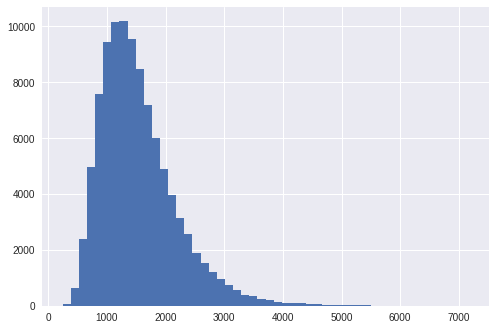

In [9]:
plt.hist(result[0], bins=50)

(array([  1.30000000e+01,   7.40000000e+01,   3.42000000e+02,
          9.04000000e+02,   1.90500000e+03,   3.50500000e+03,
          5.09300000e+03,   6.74100000e+03,   7.94300000e+03,
          8.84800000e+03,   8.96200000e+03,   8.66100000e+03,
          8.00900000e+03,   7.15700000e+03,   6.24900000e+03,
          5.21800000e+03,   4.39500000e+03,   3.48400000e+03,
          2.93900000e+03,   2.25200000e+03,   1.66800000e+03,
          1.34700000e+03,   1.07500000e+03,   7.52000000e+02,
          6.04000000e+02,   4.79000000e+02,   3.57000000e+02,
          2.64000000e+02,   1.78000000e+02,   1.46000000e+02,
          1.15000000e+02,   7.90000000e+01,   5.90000000e+01,
          5.30000000e+01,   3.40000000e+01,   2.50000000e+01,
          1.90000000e+01,   1.00000000e+01,   6.00000000e+00,
          9.00000000e+00,   8.00000000e+00,   6.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
        

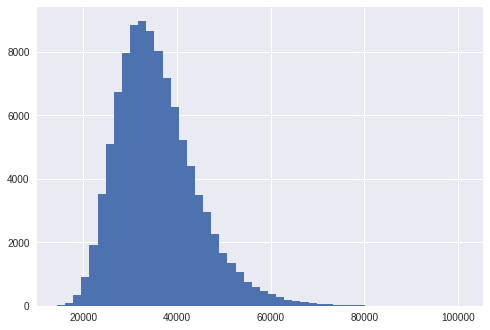

In [10]:
plt.hist(result_sum, bins=50)

In [11]:
pd.Series(result_sum).describe()

count    100000.000000
mean      35787.299180
std        8572.088652
min       14431.488430
25%       29711.092000
50%       34619.938245
75%       40582.646768
max      100979.282280
dtype: float64

In [17]:
import sys
from sklearn.ensemble import RandomForestRegressor
class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    
    def __init__(self, dfEnv, iter_random_rounds, gamma, random_state=0, test_mode=False, cash=1000, share=0, pv=0):
        super(ChimpBot, self).__init__(dfEnv, iter_random_rounds, cash, share, pv)
        # From MonkeyBot:
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        # Set random state
        self.random_state = random_state
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        
        # Chimp parameters
        self.valid_actions = ['Buy', 'Sell']
        self.gamma = gamma # Discount factor
        self.epsilon = 1 # Exploration-exploitation
        self.test_mode = test_mode
        self.random_rounds = iter_random_rounds # Number of rounds where the bot chooses to go monkey
        self.num_features = len(dfEnv.columns) # Use every columns from the input data
        
        # Turn input data into index, row
        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = next(self.iter_env)

        # Numpy alternative
#         self.env_arr = self.env.values
#         self.now_row = 0

        # May need to put back later
#         self.prev_cash = self.cash
#         self.prev_share = self.share
#         self.prev_pv = self.pv

        # Q-table and q_df
        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        # Misc
        self.reset_counter = 0

    def make_q_df(self):
        """Make a q_df out of the q_dict."""
#         print("Making q_df...")
        result_dict = defaultdict(list)
        for index, row in self.q_dict.items():
            for i in range(len(list(self.q_dict.keys())[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features - 1 + 1 + 1)] # features + action
        q_df_column_list.append('Q')
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

#         print(self.q_df.head())
        self.q_df.ix[:, -2] = self.q_df.ix[:, -2].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int) # Maybe useless

    def split_q_df(self):
        """Splitting q_df into features and labels."""
        
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]

    def train_on_q_df(self):
        """Model the q_df."""
#         print("Training on q_df...")
        self.q_reg = RandomForestRegressor(n_estimators=2000, max_features='sqrt', n_jobs=-1, random_state=self.random_state)
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
        """1. Make q_df
           2. Split q_df
           3. Train on q_df
        """
#         print("Updating Q model...")
#         start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        """Make prediction using self.reg"""
        state_action = [state_action]
        pred_q = self.q_reg.predict(state_action)

        return pred_q

    def max_q(self):
#         print("Calculating Max Q")
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Invalid action!")

#         def str_float_int(x):
#             return int(float(x))

        max_q = None
        q_compare_dict = {}

        if len(self.now_states) != self.num_features - 1:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            # added 1 more additional features to the feature set
            self.now_states.append(act)
            now_row_key = tuple(self.now_states)

            _ = self.q_dict[now_row_key]

            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")                    
                    single_X = np.array(now_row_key)
                    # print(single_X)
#                     arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
#                     single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            self.now_states.pop()

        try:
            key, qAndT = max(q_compare_dict.items(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
            sys.exit(1)
        else:
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
#         print("Updating Q table...")
        # prev_states.append(self.prev_yes_share)
        self.prev_states.append(self.prev_action)
        prev_states_key = tuple(self.prev_states)

        if len(prev_states_key) != self.num_features - 1 + 1:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]
        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q()[1])

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)

    def reset(self):
#         print("Resetting...")
        # Portfolio change over iterations
        self.asset_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = next(self.iter_env)
#         self.now_row = 0 # Numpy option

        self.cash = 1000
        self.share = 0
        self.pv = 0

        # Delete all prevs
        del self.prev_states
        del self.prev_env_index        
        del self.prev_cash
        del self.prev_share
        del self.prev_pv
        del self.prev_action

        if self.test_mode is True:
            self.epsilon = 0
        
        else:
            if self.epsilon - 1/self.random_rounds > 0.00001: # Epislon threshold: 0.01
                self.epsilon = self.epsilon - 1/self.random_rounds
            else:
                self.epsilon = 0.00001 # Epislon threshold: 0.1
                
        self.reset_counter += 1

        if self.reset_counter % self.random_rounds == 0:
            self.update_q_model()

        if np.abs(self.epsilon - 0.00001) > 0.000001:
            self.action_list = []

    def make_decision(self):
        return self.max_q()[0]

    def update(self, cost):
        # Update state
        self.now_states = list(self.now_row)
        self.now_states.pop() # Remove Trade Price

### Numpy option
#         try:
#             self.now_states = list(self.env_arr[self.now_row])
#         except IndexError:
#             print("End of data.")
#             sys.exit(1)
#         self.now_states.pop() # Remove Trade Price

        if len(self.now_states) != self.num_features - 1:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # Update Q-table using prevs
        try:
            self.prev_states
        except AttributeError:
            pass
#             print("Running the first time...no prevs exist.")
        else:
            self.hold(self.now_row[-1])
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        # All the prev stuff!
        self.prev_states = copy(self.now_states)
        self.prev_env_index = deepcopy(self.now_env_index)
#         self.prev_env_index = self.env.index[self.now_row] # Numpy option
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv
        
        # Exploitation-exploration decisioning
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        if self.decision == 0: # if zero, go random
            action = random.choice(self.valid_actions)
        else: # else go with the policy
            action = self.make_decision()

        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1], cost)
#             self.buy(self.env_arr[self.now_row][-1], cost) # Numpy option
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1], cost)
#             self.sell(self.env_arr[self.now_row][-1], cost) # Numpy option
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
#             self.hold(self.env_arr[self.now_row][-1]) # Numpy option
        else:
            raise ValueError("Invalid action man!")
        
        self.prev_action = action
        
#         self.now_row += 1 # Numpy option

        try:
            self.now_env_index, self.now_row = next(self.iter_env)
        except StopIteration:
            pass

    def simulate(self, cost=None):
        start_time = time.time()

        for i in range(self.random_rounds):
            for l in range(len(self.env)):
#             for l in range(len(self.env_arr)): # Numpy option
                self.update(cost)
            self.reset()
            if (i + 1) % 500 == 0:
                print(self.asset_history_list[-1])
                print("Round {} finished".format(i + 1))
#             print(self.asset_history_list[-1])
#             print("Round {} finished".format(i + 1))
        print("{0} rounds of simulation with cost = {1}, took {2} seconds".format(self.random_rounds, cost, time.time() - start_time))
        return self.asset_history_list, self.action_list

In [ ]:
from collections import defaultdict
from copy import copy

def chimp_simulate(data_full, target_data, num_iter, gamma, train_size, batch_size, random_state=0):
    pv_history_list = []
    action_lists = []
    # Initiating data and the chimp
    start_date = target_data.index[0]
    end_date = target_data.index[-1]
    
    dfFull = data_full
    date_range = target_data.index[:] # Using 7 months of data to predict one month
    print(date_range)
    
    batch_count = 0
        
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for batch in range(len(target_data) // batch_size + 1):
        
#     for date in date_range:
        batch_count += 1
        print("Batch {}".format(batch_count))

        try:
            dfTest = dfFull.ix[target_data.index[batch * batch_size]:target_data.index[batch * batch_size + batch_size - 1]]
        except IndexError:
            print("Last batch size unmatched...but may be fine!")
            try: 
                dfTest = dfFull.ix[target_data.index[batch * batch_size]:target_data.index[-1]]
            except IndexError:
                print("End of data")
                return (pv_history_list, action_lists)
        
        (u,) = dfFull.index.get_indexer_for([target_data.index[batch * batch_size]])

        dfTrain = dfFull.iloc[u - (train_size):u]

        chimp_train = ChimpBot(dfTrain, iter_random_rounds=num_iter, gamma=gamma, random_state=0)

        for i in range(num_iter):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update('high')
            chimp_train.reset()

        # Test the Chimp!
#         q_df = deepcopy(chimp_train.q_df)
#         q_dict = deepcopy(chimp_train.q_dict)
#         q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
                    
#             now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, iter_random_rounds=num_iter, gamma=gamma, random_state=0)
        
        chimp_test.q_df = deepcopy(chimp_train.q_df)
        chimp_test.q_dict = deepcopy(chimp_train.q_dict)
        chimp_test.q_reg = deepcopy(chimp_train.q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.cash = cash
            chimp_test.share = share
            chimp_test.pv = pv
            
            chimp_test.prev_states = prev_states
#             chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
#             chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")

        for l in range(len(chimp_test.env)):
            # print("Train Round {0}-{1}".format(i + 1, l + 1))
            chimp_test.update(None)
            action_lists.append(chimp_test.action_list)
            pv_history_list.append(chimp_test.cash + chimp_test.pv)

                
        # Create cheatsheet for the next chimp
        cash = chimp_test.cash
        share = chimp_test.share
        pv = chimp_test.pv
            
        prev_states = chimp_test.prev_states
#         now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
#         prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv
        
        if (batch + 1) % 3 == 0:
            print(pv_history_list)
        
    print(pv_history_list)
    
#     return (pv_history_list, action_lists)
    return pv_history_list

In [ ]:
validation_phase_data = stocks_converted[1216].ix[validation_start_date:validation_end_date]

# start_time = time.time()
result_list = chimp_simulate(data_full=stocks_converted[1216], target_data=validation_phase_data, num_iter=5000, gamma=0.75, train_size=21*35, batch_size=7, random_state=0)
print("\nSimulation for Test set took {} seconds.".format(time.time() - start_time))

DatetimeIndex(['2007-02-06', '2007-02-07', '2007-02-08', '2007-02-09',
               '2007-02-12', '2007-02-13', '2007-02-14', '2007-02-26',
               '2007-02-27', '2007-03-01',
               ...
               '2012-01-18', '2012-01-30', '2012-01-31', '2012-02-01',
               '2012-02-02', '2012-02-03', '2012-02-06', '2012-02-07',
               '2012-02-08', '2012-02-09'],
              dtype='datetime64[ns]', length=1230, freq=None)
Batch 1